In [1]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.integrate import odeint
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import pickle
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix


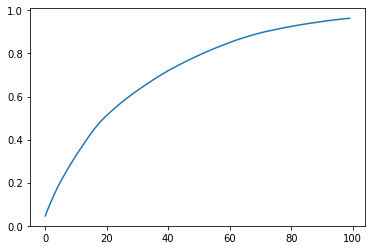

In [2]:
n_pca = 100
eta_list = np.load('/sanssauvegarde/homes/s17ouala/Complement/pytorch/ROMs_ID/Shallow_water/shallow-water-master/eta_list.npy')
elev = np.array(eta_list).reshape((np.array(eta_list).shape[0],np.array(eta_list).shape[1]*np.array(eta_list).shape[1]))#np.reshape(np.array(eta_list)[:,35:55,35:55],(100000-1,20*20))
pca = PCA(n_components=n_pca)
pca.fit(elev)
l=pca.fit_transform(elev[:])
ks_t = pca.inverse_transform(l)
plt.plot(pca.explained_variance_ratio_.cumsum())

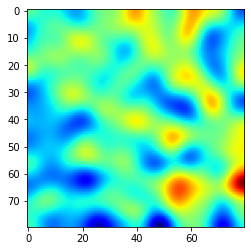

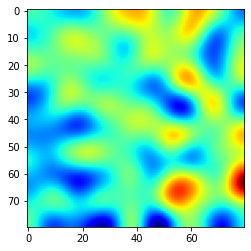

In [3]:
plt.figure(0)
plt.imshow(elev[5000,:].reshape(80,80),cmap = 'jet')
plt.figure(1)
plt.imshow(ks_t[5000,:].reshape(80,80),cmap = 'jet')

In [4]:
X_train = l[2500:-9999,:]
X_test = l[-9999:,:]
batch_size = X_train.shape[0]
nb_batch = int(X_train.shape[0]/batch_size)
dt_integration = 0.01
Grad_t   = np.gradient(X_train)[0].reshape(X_train.shape[0],n_pca)/dt_integration
X_train = X_train.reshape(nb_batch,batch_size,n_pca)
X_train = X_train[0,:,:]
Grad_t  = Grad_t.reshape(nb_batch,batch_size,n_pca)
dim = n_pca
dim_aug = 700

In [5]:
params = {}
params['length_embed'] = 200
params['delay_embed']  = 1

In [6]:
H = X_train.T[:,params['delay_embed']:-(params['length_embed']*params['delay_embed'])+params['delay_embed']]
for i in range(2,params['length_embed']):
    H = np.concatenate((H,X_train.T[:,i*params['delay_embed']:-(params['length_embed']*params['delay_embed'])+i*params['delay_embed']]))
H = np.concatenate((H,X_train.T[:,params['length_embed']*params['delay_embed']:]))

In [7]:
X_test_init = X_test[:,:]
HT = X_test_init.T[:,params['delay_embed']:-(params['length_embed']*params['delay_embed'])+params['delay_embed']]
for i in range(2,params['length_embed']):
    HT = np.concatenate((HT,X_test_init.T[:,i*params['delay_embed']:-(params['length_embed']*params['delay_embed'])+i*params['delay_embed']]))
HT = np.concatenate((HT,X_test_init.T[:,params['length_embed']*params['delay_embed']:]))

In [8]:
svd = TruncatedSVD(n_components=150, n_iter=7, random_state=42)
v = svd.fit_transform(H.T)
Train_X_EDMD = v[:-1,:]
Train_Y_EDMD = v[1:,:]
A_EDMD  = np.dot(np.linalg.pinv(Train_X_EDMD[:,:]),Train_Y_EDMD[:,:]).T

In [9]:
pred_EDMD = np.zeros((X_test.shape[0],Train_Y_EDMD.shape[-1]))# np.zeros_like(X_test)
v_init = svd.transform(HT.T)
pred_EDMD[:1,:] = v_init[200:201,:]#v_init[-1:,:]#Train_Y_EDMD[-1:,:]# 
for i in range(X_test.shape[0]-1):
    pred_EDMD[i+1,:] = np.dot(A_EDMD,pred_EDMD[i,:].T).T
pred_EDMD_VDP = svd.inverse_transform(pred_EDMD)

In [10]:
X_test_shifted = X_test[200:,:]
y_pred2 = pred_EDMD_VDP[:X_test_shifted.shape[0],:100]

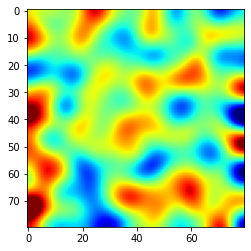

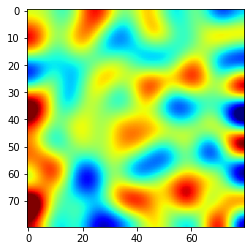

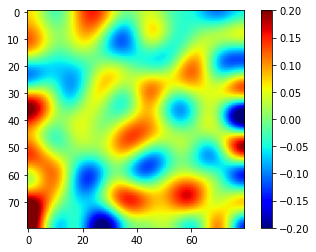

In [11]:
forecast_0 = pca.inverse_transform(y_pred2[:,:dim])
test_start = -9999
plt.figure(0)
plt.imshow(elev[test_start+200+200,:].reshape(80,80),cmap = 'jet',    vmin=-0.2, vmax = 0.2)
plt.figure(1)
plt.imshow(ks_t[test_start+200+200,:].reshape(80,80),cmap = 'jet',    vmin=-0.2, vmax = 0.2)
plt.figure(2)
plt.imshow(forecast_0[200,:].reshape(80,80),cmap = 'jet',    vmin=-0.2, vmax = 0.2)
plt.colorbar()

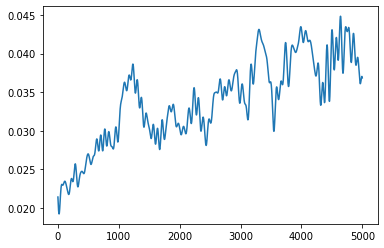

In [12]:
def RMSE(a,b):
    """ Compute the Root Mean Square Error between 2 n-dimensional vectors. """
    if (a.ndim==1):
        a = a[np.newaxis]
    if (a.ndim>2):
        a = a.reshape(a.shape[0],-1)
    if (b.ndim==1):
        b = b[np.newaxis]    
    if (b.ndim>2):
        b = b.reshape(b.shape[0],-1)
    return np.sqrt(np.nanmean((a-b)**2,1))

plt.plot(RMSE(forecast_0[:5000,:],elev[test_start+200:test_start+200+5000,:]))